This notebook is an implementation of a continuous Hopfield network for the purpose of remembering images.

It uses the continuous updating rule of $\tau_i \frac{dV_i}{dt} = -V_i + g_\beta (u_i) = -V_i + g_\beta (\sum_j W_{ij}V_j)$

Cheat sheet:

- $V$ is a vector of all the neurons. In our case, each neuron represents a pixel where the value is between $[-1, 1]$
- $g_\beta$ is a continuous non-linear function. In our case, we use tanh, which outputs values between $[-1, 1]$
- $W$ is the symmetric weight matrix representing the connections between neurons. $W_{ii} = 0$ and $W_{ij} = W_{ji}$. It is initialized by setting $W_{ij} = V_iV_j$ where $V$ is initialized to the state you want the network to "memorize". If you want the network to remember multiple of these states, simply set $W$ to the sum of all the $W$ matrices, one computed for each state.


In [1]:
import numpy as np

# Grayscale

In [2]:
import matplotlib.pyplot as plt

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

num_images = 3
data_file_path = "data_batch_1"
data = unpickle(data_file_path)[b'data']
images = []

color_enabled = True
num_neurons = 3072

X = np.empty((num_neurons, 0))

for i in range(num_images):
    grayscale_img = np.mean(data[i].reshape((3,1024)), axis=0)
    X = np.hstack((X, grayscale_img.reshape(-1, 1)))
    grayscale_img = grayscale_img.reshape((32,32))
    plt.imshow(grayscale_img, cmap="gray", interpolation='none')
    plt.axis('off')
    plt.show()
    grayscale_img = (grayscale_img - 127.5) / 127.5 # normalizing between [-1, 1]
    images.append(grayscale_img)

color_enabled = False
num_neurons = 1024
W = np.zeros((num_neurons, num_neurons))

# computes W_{ij} = V_i * V_j for all i and j. (Saves all images in weight matrix)

for image in images:
    image_normalized = image / np.linalg.norm(image)
    W += np.outer(image_normalized, image_normalized) 

W = W / num_images

np.fill_diagonal(W, 0)

FileNotFoundError: [Errno 2] No such file or directory: 'data_batch_1'

# Color

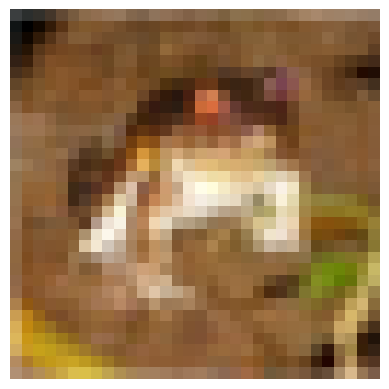

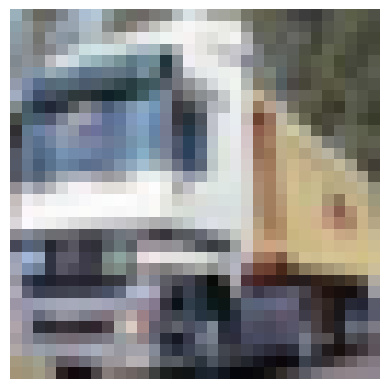

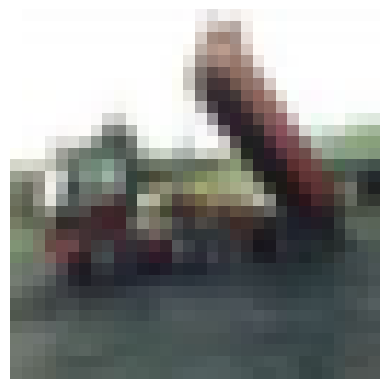

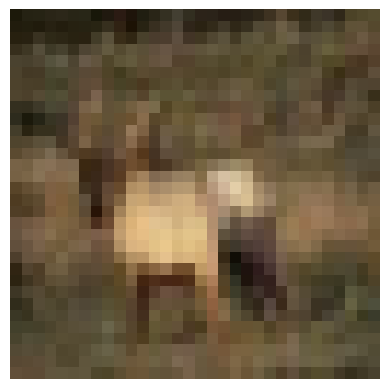

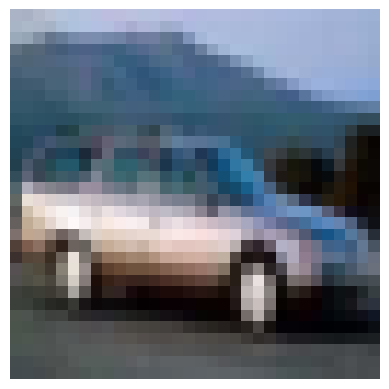

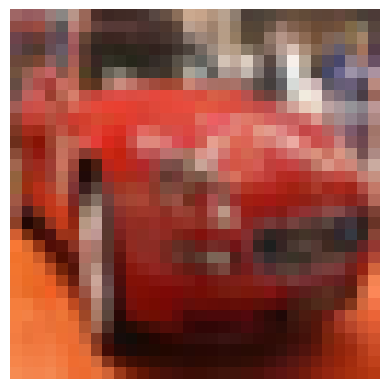

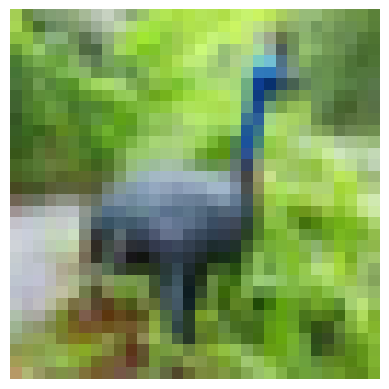

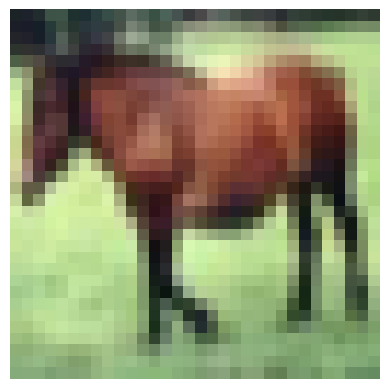

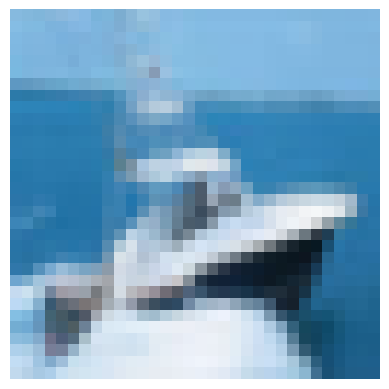

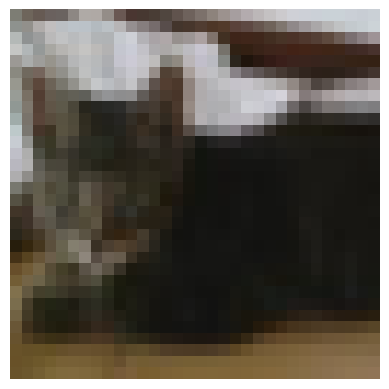

In [ ]:
import matplotlib.pyplot as plt

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

num_images = 10
data_file_path = "data_batch_1"
data = unpickle(data_file_path)[b'data']
images = []

color_enabled = True
num_neurons = 3072

X = np.empty((num_neurons, 0))

norms = []

for i in range(num_images):
    color_img = data[i].reshape((3,32,32)).transpose(1,2,0)   
    norms.append(np.linalg.norm(color_img))

nparr = np.array(norms)
min_norm = np.min(nparr)

for i in range(num_images):
    color_img = data[i].reshape((3,32,32)).transpose(1,2,0)    
    plt.imshow(color_img, interpolation='none')
    plt.axis('off')
    plt.show()
    color_copy = color_img / (norms[i] / min_norm)
    X = np.hstack((X, color_copy.flatten().reshape(-1, 1)))
    color_img = (color_img - 127.5) / 127.5 # normalizing between [-1, 1]
    images.append(color_img)


W = np.zeros((num_neurons, num_neurons))

# computes W_{ij} = V_i * V_j for all i and j. (Saves all images in weight matrix)

for image in images:
    W += np.outer(image, image) 

W = W / num_images

np.fill_diagonal(W, 0)

In [66]:
from scipy.integrate import solve_ivp

def cosine_similarity(x, y):
    return np.dot(x, y) / (np.linalg.norm(x) * np.linalg.norm(y))

# constants
def g(u, beta = 7):
    return np.tanh(u * beta)

def sigmoid(u, scaling_factor=2):
    return 1 / (1 + np.exp(-u / scaling_factor))

def energy(v):
    return -0.5 * g(v).T @ W @ g(v) + np.sum(np.log(np.cosh(v)))

tol = 1e-4 # integrate until converging to this tolerance
dt = 0.001

def hopfield_diff_eq(t, v):
    dvdt = (-v + W @ g(v))
    return dvdt

In [67]:
# If you want random noise, choose the top V. If you want to start it at a specific image, choose the bottom V.

V = np.random.uniform(-1.0, 1.0, size=(num_neurons))
# V = images[2].flatten()
# choice = np.random.choice(len(images))
# print(choice)
# V = images[choice].flatten()

time = 0 # for integration, this is the starting time at first
times = [time]
states = [V]

current_state = V
prev_state = V + 2 * tol # This makes the first iteration of the loop work

# while np.abs(current_state - prev_state).max() > tol:
#     prev_state = current_state
#     result = solve_ivp(hopfield_diff_eq, (time, time + dt), current_state, method='RK45', t_eval=[time+dt])
    
#     current_state = result.y[:, -1]
#     time += dt
#     times.append(time)
#     # states.append(current_state)
#     # current_state = prev_state + hopfield_diff_eq(0, prev_state) * dt
#     states.append(current_state)


result = solve_ivp(hopfield_diff_eq, (0, 100), current_state, method='RK45', t_eval=[100])
states.append(result.y[:, -1])

times = np.array(times)
states = np.array(states)



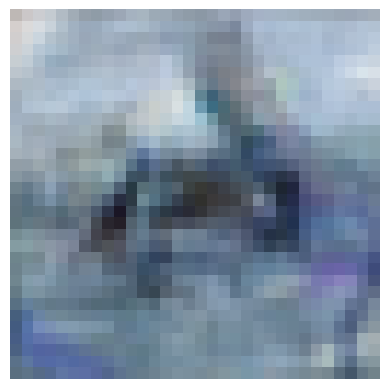

In [71]:
if color_enabled:
    final_img = states[-1].reshape((32,32,3))
else:
    final_img = states[-1].reshape((32,32))

final_img = (final_img+1)/2

if color_enabled:
    plt.imshow(final_img, interpolation='none')
else:
    plt.imshow(final_img, cmap="gray", interpolation='none')
plt.axis('off')
plt.show()

In [6]:
def invert(image):
    return 1-image

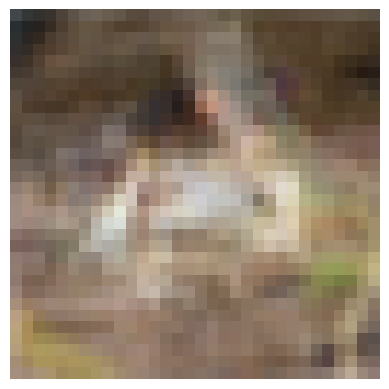

In [7]:
negative = invert(final_img)

if color_enabled:
    plt.imshow(negative, interpolation='none')
else:
    plt.imshow(negative, cmap="gray", interpolation='none')
plt.axis('off')
plt.show()

In [264]:
for image in images:
    print(cosine_similarity(final_img.flatten(), image.flatten()))

-0.494532144632739
0.018819212847012108
0.08106848660224104
-0.8310007822988416
-0.37610003165430167
-0.5892251502245595
-0.1879099234215986
-0.127535758369217
0.41921511804214767
-0.7118951554379563


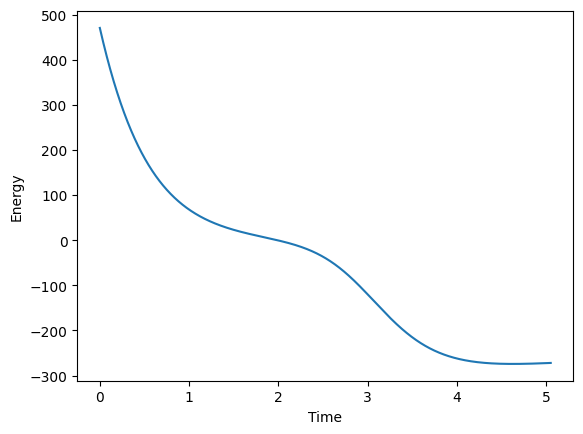

In [216]:
energies = [energy(state) for state in states]
plt.plot(times, energies)
plt.xlabel("Time")
plt.ylabel("Energy")
plt.show()

# Hopfield Networks is all you need

In [73]:
def softmax(x):
    x = x - np.max(x)
    exp_x = np.exp(x)
    return exp_x / np.sum(exp_x)

def modern_hopfield_step(X,xi,beta=1):
    xinew = X@softmax(beta*X.T@xi)
    return xinew

def modern_hopfield_step_normalization(X, xi, beta=0.0001):
    # Normalize X columns and xi for similarity calculation
    X_norm = X / np.linalg.norm(X, axis=1, keepdims=True)
    xi_norm = xi / np.linalg.norm(xi)
    
    # Compute new state
    similarities = X_norm.T @ xi_norm  # Cosine similarities
    xinew = X @ softmax(beta * similarities)
    return xinew


In [227]:
# V = np.random.uniform(0.1, 255.0, size=(num_neurons))
V = X[:, 0]
choice = np.random.choice(len(images))
print(choice)
V = X[:, choice]

current_state = V + 0.01 * np.random.randn(*V.shape)
prev_state = V + 2 * tol

states = [current_state]

iter_count = 0

while np.abs(current_state - prev_state).max() > tol:
    iter_count += 1 
    prev_state = current_state
    current_state = modern_hopfield_step(X, prev_state)
    states.append(current_state)

print(iter_count)


if color_enabled:
    for img in states:
        print(np.min(img))
        final_img = img.reshape((32,32,3)) / 255.0
        plt.imshow(final_img, interpolation='none')
        plt.axis('off')
        plt.show()
else:
    for img in states:
        final_img = img.reshape((32,32)) / 255.0
        plt.imshow(final_img, cmap="gray", interpolation='none')
        plt.axis('off')
        plt.show()

NameError: name 'X' is not defined

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-5.796058103454013e-05..1.0000338417177868].


-0.014779948163807732


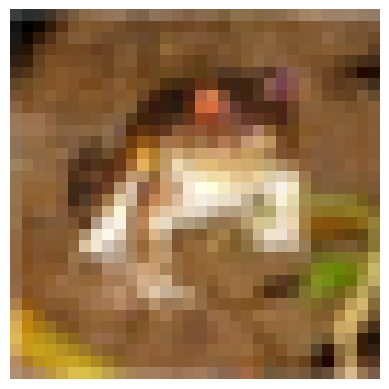

35.66446885406572


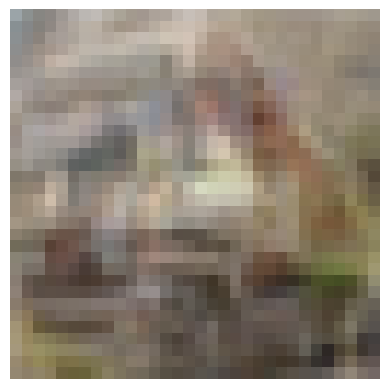

35.669526459927226


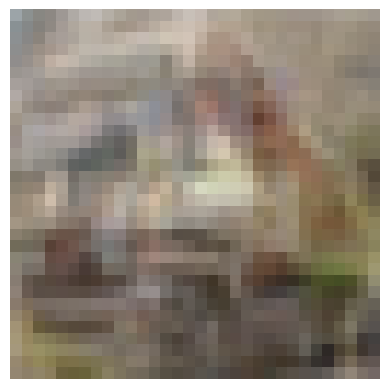

35.6695282329523


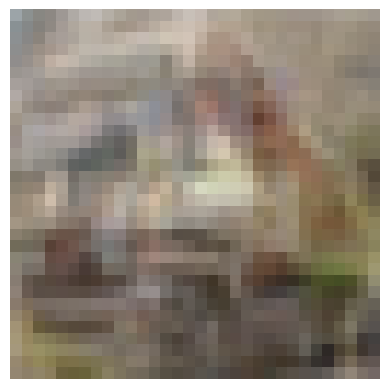

In [41]:
if color_enabled:
    for img in states:
        print(np.min(img))
        final_img = img.reshape((32,32,3)) / 255.0
        plt.imshow(final_img, interpolation='none')
        plt.axis('off')
        plt.show()
else:
    for img in states:
        final_img = img.reshape((32,32)) / 255.0
        plt.imshow(final_img, cmap="gray", interpolation='none')
        plt.axis('off')
        plt.show()

In [407]:
np.min(X)

0.0

In [306]:
current_state

array([255., 255., 255., ...,  80.,  86.,  84.])

In [345]:
V = X[:, 0]
V.shape

(3072,)

In [436]:
for i in range(X.shape[1]):
    print(np.linalg.norm(X[:,i]))

6416.603462892186
7964.367457620222
8711.389843188055
4884.421255379188
6644.910006915067
6039.182808956854
7257.420133904334
7504.499450329782
9085.38689324786
5034.667417019718


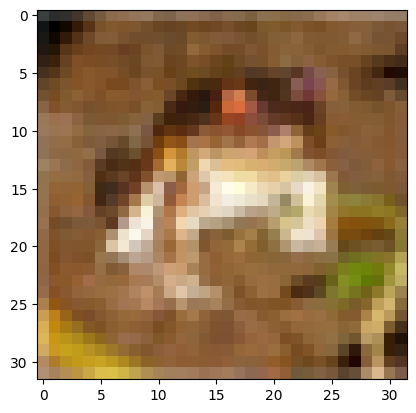

In [438]:
plt.imshow(X[:, 0].reshape((32,32,3)) / 255.0, interpolation='none')

# Discrete hopfield networks

In [170]:
import numpy as np
import matplotlib.pyplot as plt

def show_image(img, shape=(32,32)):
    final_img = img.reshape(shape)
    plt.figure(figsize=(2,2))
    plt.imshow(final_img, cmap="gray", interpolation='none')
    plt.axis('off')
    plt.show()

# returns flattened images
def generate_uncorrelated_images(num_images, size: int, correlation_threshold):
    images = []

    while len(images) < num_images:
        image = np.random.choice([-1, 1], size=size)
        is_uncorrelated = True
        for existing_image in images:
            correlation = abs(float(get_hamming_distance(existing_image, image)) / float(size))
            if correlation > correlation_threshold:
                is_uncorrelated = False
                break

        if is_uncorrelated:
            images.append(image)
            print(f"{len(images)} uncorrelated images")

    return np.array(images)

def discrete_update(num_neurons, W, states):
    i = np.random.randint(0, num_neurons)
    new_state = states[-1].copy()
    new_state[i] = np.sign(W[i,:]@new_state)
    return new_state

def discrete_energy(W, state):
    return -0.5 * state @ W @ state

def get_hamming_distance(img1, img2):
    if len(img1) != len(img2):
        print(f"Images must be same size, but have sizes {img1.shape} and {img2.shape}")
        exit(1)
    return len(img1) - np.count_nonzero(img1 == img2)

def hamming_distance_matrix(flattened_images):
    num_images = len(flattened_images)
    distances = np.empty((num_images, num_images,))
    for i in range(num_images):
        for j in range(num_images):
            distances[i,j] = get_hamming_distance(flattened_images[i], flattened_images[j])
            distances[j,i] = get_hamming_distance(flattened_images[i], flattened_images[j])
    print(distances)

# Outputs an array in the format [closest_input_image_index, hamming_distance_from_closest_input_image]
def is_valid_memory(images, output_image, print_output=True):
    closest_ham = len(output_image)
    closest_index = -1
    for i in range(len(images)):
        ham = get_hamming_distance(images[i], output_image)
        inv_ham = get_hamming_distance(images[i], output_image * -1)
        if ham == 0 or inv_ham == 0:    # Checking for inverted 
            if print_output:
                print(f"Match for image {i}")
            return [i, 0]
        
        if ham < closest_ham:
            closest_ham = ham
            closest_index = i
        if inv_ham < closest_ham:
            closest_ham = inv_ham
            closest_index = i
    if print_output:
        print(f"Mutant, closest was image {closest_index} with hamming distance of {closest_ham}")
    return [closest_index, closest_ham]


def discrete_hopfield_trials(W, images, num_iter, num_trials):
    tol = 0.000001
    result = np.empty((num_trials, 2,))
    
    for trial in range(num_trials):
        V = np.random.choice([-1,1],size=len(images[0]))
        prev_state = V + 2 * tol # This makes the first iteration of the loop work
        states = [prev_state, V]

        for i in range(num_iter):
            states.append(discrete_update(num_neurons, W, states))
        temp = is_valid_memory(images, states[-1], print_output=False)
        result[trial][0] = temp[0]
        result[trial][1] = temp[1]
    return result.astype(int)

def load_mnist_images(file_path):
    threshold = 255/2
    data = np.loadtxt(file_path, delimiter=',', )
    labels = data[:, 0].astype(int)
    images = data[:, 1:]
    images[images < threshold] = -1
    images[images > threshold] = 1
    return labels, images

# E.g. if target_label = 9, return data from random image of a 9 in mnist
def get_mnist_by_label(labels, images, target_label):
    target_label_indices = np.where(labels == target_label)[0]
    filtered_images = images[target_label_indices]
    return filtered_images[np.random.randint(0, len(filtered_images))]
    


## MNIST images

In [ ]:
# setup
image_shape = (28, 28,)
num_neurons = 28 * 28
num_trials = 1000
tol = 0.000001
desired_labels = [0,1,2,3,4,5,6,7,8,9]
labels, images = load_mnist_images("mnist_test.csv")

# store data
true_correct = []    # each entry is input that was correctly identified
incorrect = []  # each entry is (correct memory, incorrect memory it converged to)
incorrect_predictions = []    # each entry is the input that it got wrong
correct_predictions = []

for trial in range(num_trials):
    trial_images = []
    for l in desired_labels:
        trial_images.append(get_mnist_by_label(labels, images, l))
    trial_images = np.array(trial_images)

    W = trial_images.T @ trial_images
    W = W / num_images
    np.fill_diagonal(W, 0.0)

    input_label = np.random.choice(desired_labels)
    V = get_mnist_by_label(labels, images, input_label)

    prev_state = V + 2 * tol # This makes the first iteration of the loop work
    states = [prev_state, V]

    for i in range(num_trials):
        states.append(discrete_update(num_neurons, W, states))
    temp = is_valid_memory(trial_images, states[-1], print_output=False)
    closest_image = desired_labels[temp[0]]
    hamming_from_closest = temp[1]

    if hamming_from_closest == 0 and closest_image == input_label:
        true_correct.append(closest_image)
        correct_predictions.append(closest_image)
    elif hamming_from_closest == 0 and closest_image != input_label:
        incorrect.append((input_label, closest_image))
        incorrect_predictions.append(closest_image)
    else:
        if input_label == closest_image:
            correct_predictions.append(closest_image)
        else:
            incorrect_predictions.append(closest_image)

print("true correct", true_correct)
print("true incorrect", incorrect)
print("correct predictions", correct_predictions)
print("incorrect predictions", incorrect_predictions)
print("correct predictions len", len(correct_predictions))
print("incorrect predictions len", len(incorrect_predictions))

true correct []
true incorrect []
correct predictions [0, 1, 5, 1, 1, 1, 1, 1, 6, 3, 4, 1, 4, 1, 7, 7, 3, 6, 1, 1, 1, 1, 1, 4, 8, 7, 9, 1, 9, 1, 1, 1, 1, 1, 5, 6, 1, 1, 1, 5, 1, 4, 9, 1, 5, 4, 1, 4, 7, 1, 4, 7, 6, 4, 2, 1, 1, 7, 5, 7, 1, 7, 6, 0, 7, 4, 9, 1, 6, 7, 3, 1, 3, 1, 4, 4, 1, 0, 1, 9, 3, 1, 1, 1, 9, 9, 6, 3, 7, 8, 1, 8, 4, 1, 7, 4, 1, 7, 1, 0, 1, 9, 9, 2, 9, 1, 1, 7, 3, 1, 7, 1, 1, 1, 9, 1, 1, 7, 1, 9, 1, 1, 9, 9, 9, 1, 0, 1, 7, 3, 1, 3, 1, 1, 9, 5, 1, 1, 7, 4, 3, 1, 1, 3, 3, 1, 9, 1, 1, 7, 7, 1, 9, 1, 4, 1, 1, 1, 7, 7, 1, 3, 4, 8, 1, 1, 9, 1, 1, 1, 7, 1, 3, 4, 1, 1, 9, 1, 1, 7, 6, 4, 7, 1, 8, 7, 4, 6, 1, 0]
incorrect predictions [1, 9, 1, 9, 1, 4, 1, 8, 5, 1, 1, 1, 7, 7, 5, 8, 8, 7, 9, 1, 1, 8, 1, 4, 9, 1, 7, 9, 1, 5, 7, 7, 1, 1, 1, 1, 8, 1, 6, 9, 7, 1, 9, 1, 1, 9, 1, 1, 1, 1, 5, 4, 5, 1, 9, 4, 1, 1, 7, 1, 7, 9, 9, 1, 7, 1, 7, 9, 1, 8, 1, 1, 3, 9, 1, 4, 7, 1, 1, 7, 1, 4, 4, 9, 7, 8, 7, 4, 3, 4, 5, 1, 1, 1, 5, 1, 7, 1, 7, 7, 7, 1, 1, 9, 7, 3, 7, 4, 7, 6, 1, 6, 4, 8, 1, 1, 9, 9

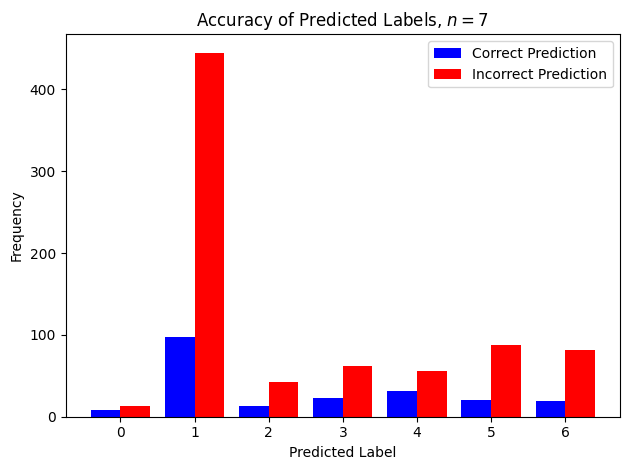

In [ ]:
# Create bar chart
correct_prediction_frequencies = np.bincount(correct_predictions, minlength=len(desired_labels))
incorrect_prediction_frequencies = np.bincount(incorrect_predictions, minlength=len(desired_labels))
x = np.arange(len(desired_labels))
width = 0.4
plt.bar(x - width/2, correct_prediction_frequencies, width=width, label="Correct Prediction", color="blue")
plt.bar(x + width/2, incorrect_prediction_frequencies, width=width, label="Incorrect Prediction", color="red")

plt.xlabel("Predicted Label")
plt.ylabel("Frequency")
plt.title(f"Accuracy of Predicted Labels, $n={len(desired_labels)}$")
plt.xticks(x, labels=desired_labels)
plt.legend()
plt.tight_layout()
plt.show()

## Randomly generated Images

In [ ]:
# Create images
num_images = 30
image_length = 32 * 32
image_shape = (32, 32,)
images = generate_uncorrelated_images(num_images, image_length, 0.5)

hamming_distance_matrix(images)

for image in images:
    show_image(image)
color_enabled = False
num_neurons = 1024

In [ ]:
# setup
image_length = 32 * 32
image_shape = (32, 32,)
num_neurons = 1024
num_trials = 1000
num_images_arr = np.array([1, 2, 3, 5, 10, 15, 20, 25, 30])

# store output
num_correct_arr = []
mci_arr = []  # mci = Most Common Incorrect image index
mci_proportion_arr = [] # number of times hopfield incorrectly guessed mci / total # times it recalled wrong memory
bar_chart_data = {}
pie_chart_data = {}
# loop
for num_images in num_images_arr:
    trial_images = images[0:num_images]
    W = trial_images.T @ trial_images
    W = W / num_images
    np.fill_diagonal(W, 0.0)
    data = discrete_hopfield_trials(W, trial_images, 10000, num_trials)

    num_correct = np.sum(data[:, 1] == 0)
    num_incorrect = num_trials-num_correct

    correct_data = data[data[:, 1] == 0, :]
    pie_counts, pie_bins = np.histogram(correct_data[:,0], bins=np.arange(0, num_images+1, 1))
    print(bins)
    pie_chart_data[num_images] = [pie_counts, pie_bins]
    
    print("num_images: ", len(trial_images))
    print("num_correct: ", num_correct)
    print("num_incorrect: ", num_incorrect)
    print("Percent correct: ", float(num_correct)/float(num_trials))

    if num_incorrect == 0:
        num_correct_arr.append(num_correct)
        mci_arr.append(np.nan)
        mci_proportion_arr.append(np.nan)
    else:
        incorrect_data = data[data[:, 1] > 0, :] 
        counts, bins = np.histogram(data[:,1], bins=[0] + list(range(1, int(image_length/2), 100)))
        bar_chart_data[num_images] = [counts, bins]

        mci = np.argmax(counts)
        num_mci = np.sum(incorrect_data[:, 0] == mci)
        mci_proportion = num_mci/float(num_incorrect)
        num_correct_arr.append(num_correct)
        mci_arr.append(mci)
        mci_proportion_arr.append(mci_proportion)

num_correct_arr = np.array(num_correct_arr)
mci_arr = np.array(mci_arr)  
mci_proportion_arr = np.array(mci_proportion_arr)

np.savez("discrete_hopfield_data", num_correct_arr=num_correct_arr, mci_arr=mci_arr, mci_proportion_arr=mci_proportion_arr, num_images_arr=num_images_arr)


total images:  30
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
num_images:  1
num_correct:  972
num_incorrect:  28
Percent correct:  0.972
[  0   1 101 201 301 401 501]
num_images:  2
num_correct:  966
num_incorrect:  34
Percent correct:  0.966
[  0   1 101 201 301 401 501]
num_images:  3
num_correct:  711
num_incorrect:  289
Percent correct:  0.711
[  0   1 101 201 301 401 501]
num_images:  5
num_correct:  639
num_incorrect:  361
Percent correct:  0.639
[  0   1 101 201 301 401 501]
num_images:  10
num_correct:  610
num_incorrect:  390
Percent correct:  0.61
[  0   1 101 201 301 401 501]
num_images:  15
num_correct:  293
num_incorrect:  707
Percent correct:  0.293
[  0   1 101 201 301 401 501]
num_images:  20
num_correct:  107
num_incorrect:  893
Percent correct:  0.107
[  0   1 101 201 301 401 501]
num_images:  25
num_correct:  35
num_incorrect:  965
Percent correct:  0.035
[  0   1 101 201 301 401 501]
num_images:  30
num_correct:  9
n

counts [972]
bins [0]
sum 972


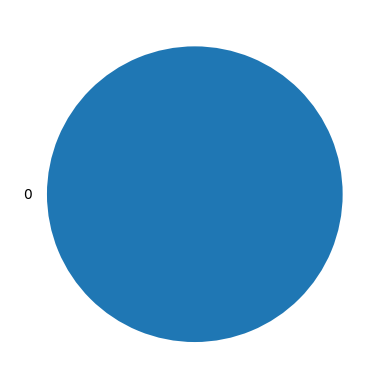

counts [496 470]
bins [0 1]
sum 966


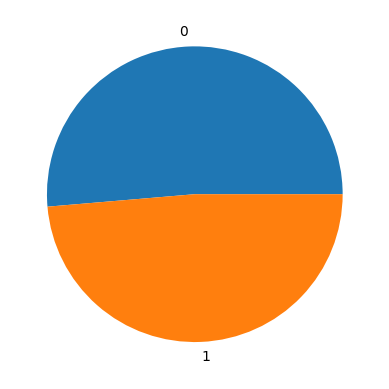

counts [247 234 230]
bins [0 1 2]
sum 711


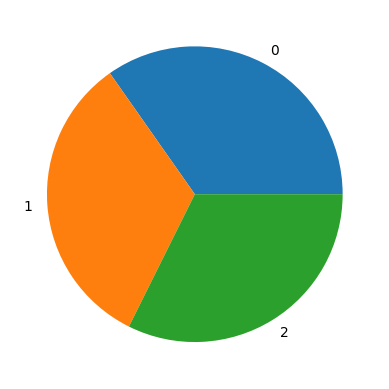

counts [119 126 145 134 115]
bins [0 1 2 3 4]
sum 639


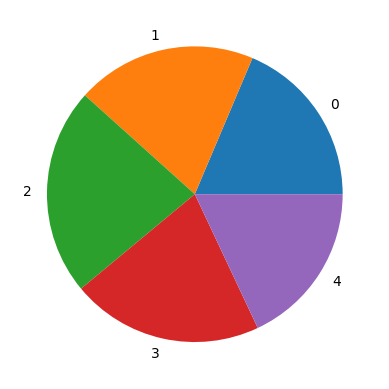

counts [58 57 71 60 58 55 75 62 61 53]
bins [0 1 2 3 4 5 6 7 8 9]
sum 610


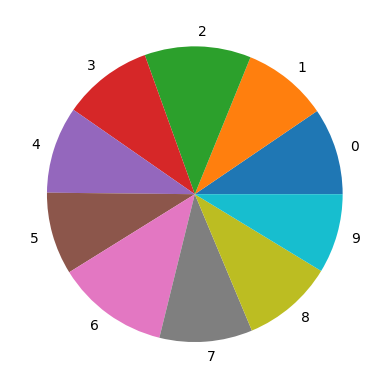

counts [24 20 18 25 13 20 21 23 18 18 16 18 20 14 25]
bins [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
sum 293


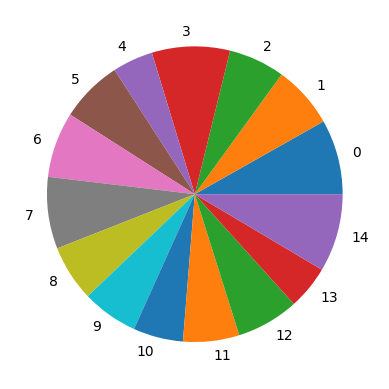

counts [ 6  6  6  9  4  5  7  3  3  6  4  6  6  7  4  5  5  2 10  3]
bins [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
sum 107


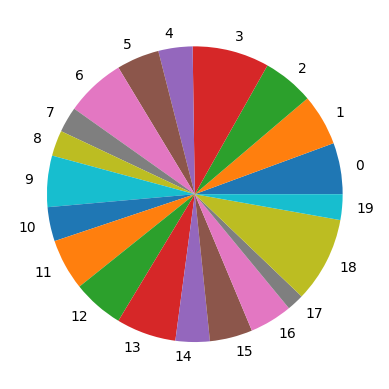

counts [2 1 2 3 4 1 2 0 0 1 0 2 2 2 2 0 1 3 3 1 0 2 0 1 0]
bins [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24]
sum 35


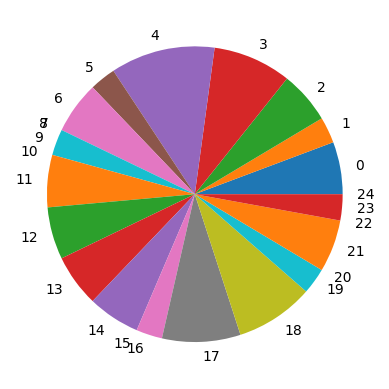

counts [0 0 0 0 0 2 0 0 0 0 0 3 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0]
bins [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
sum 9


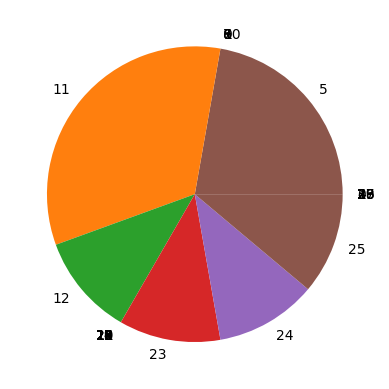

In [136]:
# Pie chart
for n in pie_chart_data.keys():
    counts = pie_chart_data[n][0]
    bins = pie_chart_data[n][1][:-1]
    print("counts", counts)
    print("bins", bins)
    print("sum", np.sum(counts))
    plt.figure()
    plt.pie(counts, labels=bins)
    plt.show()

In [ ]:
# Generate bar plot
bar_width = 10
num_bars = len(bar_chart_data.keys())
x_offsets = [(i - num_bars / 2) * bar_width for i in range(num_bars)]
print(x_offsets)
plt.figure(figsize=(8,5))
for i, (n, data) in enumerate(bar_chart_data.items()):
    counts = data[0]
    bins = data[1][:-1]
    adjusted_bins = bins + x_offsets[i]
    plt.bar(adjusted_bins, counts/float(num_trials), width=bar_width, align="center", label=f"n={n}", edgecolor="k")
    print(adjusted_bins)

plt.title(f"Effect of $n$ on Error")
plt.ylabel("Probability")
plt.xlabel("Error (Number of Incorrect Bits)")

plt.gca().set_xticks(adjusted_bins, labels=["0", "1-100", "101-200", "201-300", "301-400", "401-500"])
plt.legend()
plt.show()

Text(0.5, 1.0, 'Effect of $n$ on Probability of Zero Error')

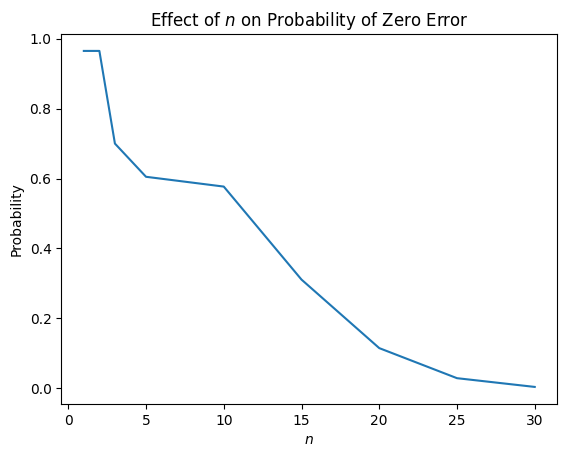

In [123]:
plt.plot(num_images_arr, num_correct_arr/float(num_trials))
plt.xlabel("$n$")
plt.ylabel("Probability")
plt.title("Effect of $n$ on Probability of Zero Error")